In [82]:
import requests
from bs4 import BeautifulSoup
import mysql.connector
import re

base_url = 'https://stackoverflow.com/tags?tab=popular'

# connection 
db = mysql.connector.connect(
    host='localhost',
    user='root',
    password='1234',
    database='mydatabase'
)
cursor = db.cursor()

# Create a table in the database 
cursor.execute("CREATE TABLE IF NOT EXISTS tags_1 (id INT AUTO_INCREMENT PRIMARY KEY, name VARCHAR(255), count INT)")

def insert_tags(tag_data):
    sql = "INSERT INTO tags_1 (name, count) VALUES (%s, %s)"
    values = [(name, count) for name, count in tag_data]
    #print(values)
    cursor.executemany(sql, values)
    db.commit()

# Fetch data from pages and store in the database
for page_num in range(1, 6):
    url = f"{base_url}&page={page_num}"

    # Send a GET request 
    response = requests.get(url)

    soup = BeautifulSoup(response.content, 'html.parser')
    code=soup
    tags_container = soup.find('div', {'id': 'tags-browser'})
    tag_items = tags_container.find_all('a', {'class': 'post-tag'})
    tag_counts = re.findall('</div>\n<div class="mt-auto d-flex jc-space-between fs-caption fc-black-400">\n<div class="flex--item">((?:.|\\n)*?)</div>',str(code))
    #tag_counts = tags_container.find_all('div', {'class': 'mt-auto d-flex jc-space-between fs-caption fc-black-400'})
#     print(tag_counts)

    # Extract the tag names and counts
    tag_data = [(tag.text, int(count.replace('questions',''))) for tag, count in zip(tag_items, tag_counts)]

    # Insert tag data into the database
    insert_tags(tag_data)

#for name, count in tag_data:
        #print(f"Tag: {name}, Count: {count}")
db.close()


### Analytics Code

In [62]:
import pandas as pd
db_config = {
    'host': 'localhost',
    'user': 'root',
    'password': '1234',
    'database': 'mydatabase'
}

# Connect to the MySQL database
cnx = mysql.connector.connect(**db_config)

# Query the data from the MySQL table
query = "SELECT name, count FROM tags_1"
df = pd.read_sql(query, cnx)

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_10476\2756728751.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, cnx)


In [63]:
df.head()

,name,count
0,javascript,2498410
1,python,2141970
2,java,1899190
3,c#,1593861
4,php,1459351


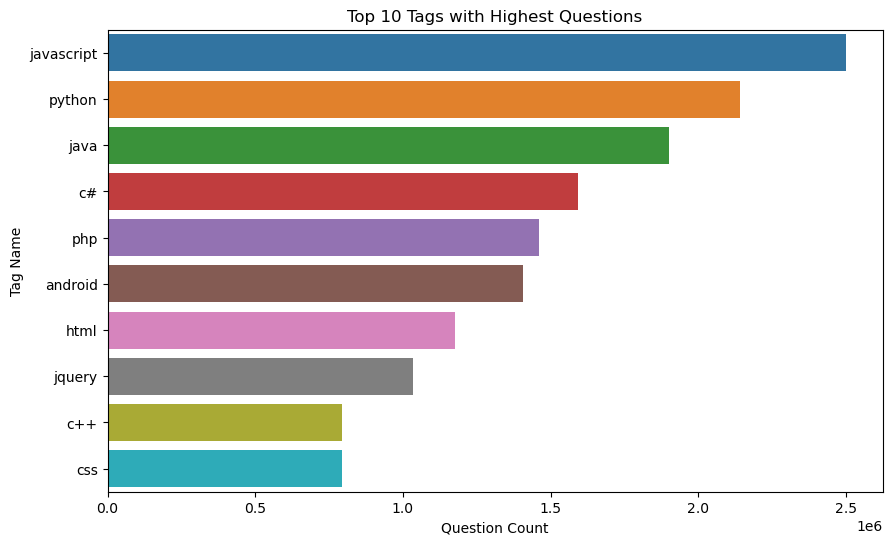

In [78]:
import mysql.connector
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

db_config = {
    'host': 'localhost',
    'user': 'root',
    'password': '1234',
    'database': 'mydatabase'
}

cnx = mysql.connector.connect(**db_config)
cursor = cnx.cursor()

query = "SELECT name, count FROM tags_1 ORDER BY count DESC LIMIT 10"
cursor.execute(query)
data = cursor.fetchall()

total_questions_query = "SELECT SUM(count) FROM tags_1"
cursor.execute(total_questions_query)
total_questions = cursor.fetchone()[0]

# Close the database connection
cursor.close()
cnx.close()

df = pd.DataFrame(data, columns=['Tag Name', 'Question Count'])

plt.figure(figsize=(10, 6))
sns.barplot(x='Question Count', y='Tag Name', data=df)
plt.title('Top 10 Tags with Highest Questions')
plt.xlabel('Question Count')
plt.ylabel('Tag Name')
plt.show()

fig = px.pie(df, values='Question Count', names='Tag Name', title='Total Questions Asked')
fig.show()
